# Train a RESNET model on the esc50 dataset

## Imports

In [1]:
# change working directory to the root of the project
import os
os.chdir("../")
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /workspaces/GADME


In [2]:
# imports
from omegaconf import OmegaConf
import torchvision
import torch
import torchmetrics.classification

from src.modules.base_module import BaseModule
from src.datamodule.esc50_datamodule import ESC50
from src.utils.ast_extractor import CustomASTFeatureExtractor


## Datamodule

In [27]:
esc50_config = OmegaConf.create({
    "dataset": {
        "data_dir": "/workspaces/GADME/data",
        "dataset_name": "esc50",
        "hf_path": "ashraq/esc50",
        "hf_name": None,
        "seed": 42,
        "feature_extractor": {
            "_target_": 'src.utils.ast_extractor.CustomASTFeatureExtractor',
            "n_classes": 50,
            "n_workers": 1,
            "column_list": ["input_values", "target"],
            "val_split": 0.2,
            "sampling_rate": 32000,
        },
        "n_classes": 50,
        "n_workers": 16,
        "column_list": ["input_values", "target"],
        "val_split": 0.2,
    },
    "loaders": {
        "train": {
            "batch_size": 6,
            "shuffle": True,
            "num_workers": 4,
            "drop_last": False,
            "pin_memory": False
        },
        "valid": {
            "batch_size": 6,
            "shuffle": False,
            "num_workers": 4,
            "drop_last": False,
            "pin_memory": False
        },
        "test": {
            "batch_size": 6,
            "shuffle": False,
            "num_workers": 4,
            "drop_last": False,
            "pin_memory": False
        },
    },
    "transforms": {
        "use_channel_dim": False,
        "normalize": True,
        "use_spectrogram": True,
        "n_fft": 1024,
        "hop_length": 79,
        "n_mels": 128,
        "db_scale": True,
        "target_height": 32,
        "target_width": 32,
        "waveform_augmentations": {
            "colored_noise": {
                "prob": 0.5,
                "min_snr_in_db": 3.0,
                "max_snr_in_db": 30.0,
                "min_f_decay": -2.0,
                "max_f_decay": 2.0
            },
        },
        "spectrogram_augmentations": {
            "time_masking": {
                "time_mask_param": 100,
                "prob": 0.5
            },
            "frequency_masking": {
                "freq_mask_param": 100,
                "prob": 0.5
            },
            "time_stretch": {
                "prob": 0.5,
                "min_rate": 0.8,
                "max_rate": 1.2
            },
        },
    },
})

In [28]:
esc50_datamodule = ESC50(dataset=esc50_config.dataset, loaders=esc50_config.loaders, transforms=esc50_config.transforms)

In [29]:
esc50_datamodule.prepare_data()

Repo card metadata block was not found. Setting CardData to empty.


Map (num_proc=16):   0%|          | 0/2000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/200 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/200 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/200 [00:00<?, ? examples/s]

In [30]:
esc50_datamodule.setup(stage="fit") 

In [31]:
train_dataloader = esc50_datamodule.train_dataloader()
batch = next(iter(train_dataloader))

In [32]:
batch['input_values'].shape

torch.Size([6, 32, 32])

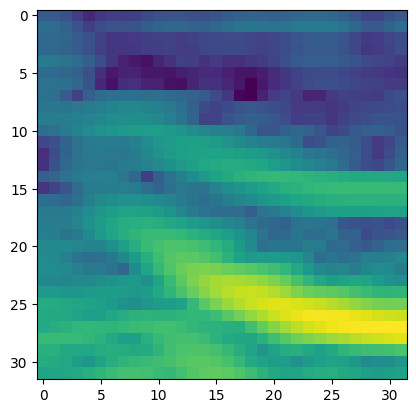

In [39]:
# plot the first spectrogram
import matplotlib.pyplot as plt
plt.imshow(batch['input_values'][3].squeeze().numpy())


## Lightning Module

In [40]:
module_config = OmegaConf.create({
    "network": {
        "model_name": "resnet50",
        "model": {
            "_target_": 'torchvision.models.resnet50',
            "weights": 'ResNet50_Weights.IMAGENET1K_V1'
        },
        "torch_compile": False
    },
    "output_activation": {
        "_target_": 'torch.softmax',
        "dim": 1
    },
    "loss": {
        "_target_": 'torch.nn.CrossEntropyLoss'
    },
    "optimizer": {
        "_target_": 'torch.optim.Adam',
        "lr": 0.001,
        "weight_decay": 0.01
    },
    "lr_scheduler": {
        "_target_": 'torch.optim.lr_scheduler',
    },
    "metrics": {
        "main": {
            "_target_": 'torchmetrics.classification.Accuracy',
            "task": "multiclass",
            "num_classes": 50,
            "top_k": 1,
        },
        "val_best": {   
            "_target_": 'torchmetrics.MaxMetric',
        }
    },
    "num_epochs": 10,
    "logging_params": None,
    "len_trainset": 50000
})

In [41]:
resnetModule = BaseModule(
    network=module_config.network,
    output_activation= module_config.output_activation,
    loss=module_config.loss,
    optimizer=module_config.optimizer,
    lr_scheduler=module_config.lr_scheduler,
    metrics=module_config.metrics,
    logging_params=module_config.logging_params,
    num_epochs=module_config.num_epochs,
    len_trainset=module_config.len_trainset
)
    

In [42]:
resnetModule

BaseModule(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
         

## Training

In [43]:
from lightning import Trainer
trainer = Trainer(max_epochs=10, devices=1)
trainer.fit(resnetModule, esc50_datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /workspaces/GADME/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name              | Type               | Params
---------------------------------------------------------
0 | model             | ResNet             | 25.6 M
1 | loss              | CrossEntropyLoss   | 0     
2 | train_metric      | MulticlassAccuracy | 0     
3 | train_add_metrics | MetricCollection   | 0     
4 | valid_metric      | MulticlassAccuracy | 0     
5 | valid_met

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

TypeError: ResNet.forward() got an unexpected keyword argument 'input_values'